# Fit emimTF2N data

EoS: SRK

Parameter T dependence: Linear in [emimTF2N,R32] direction

N (total fitting parameters): 3

**Note: Need to figure out initialization**

## Import Functions

In [1]:
import idaes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import sys
sys.path.append('../../')

from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)
from pyomo.opt import TerminationCondition, SolverStatus

from idaes.core import FlowsheetBlock
import idaes.logger as idaeslog
# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)
# Import unit models from the model library
from idaes.generic_models.unit_models import Flash
# Import degrees of freedom tool
from idaes.core.util.model_statistics import degrees_of_freedom

# parmest (binary_param2)
from bip_fitting_functions_SRK import linear

import scipy.stats as stats

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

## Load Data

In [2]:
data_full = pd.read_csv('r32_emimtf2n_full.csv')
data_subset = pd.read_csv('r32_emimtf2n_subset.csv')

## Load Configuration + Check DOF

In [3]:
from hfc32_emimtf2n_SRK import configuration 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(default={"dynamic": False})
m.fs.properties = GenericParameterBlock(default=configuration)
m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})
DOF_initial = degrees_of_freedom(m)
print('The initial DOF is {0}'.format(DOF_initial))

The initial DOF is 7


## Fit Parameters

In [5]:
parameters, obj_value, a = linear(data_subset, configuration, 'R32', 'emimTf2N', "x_R32", "x_emimTf2N", 
    init_temp =  283.1, init_press =   399300 , init_x_c1 =    0.448, init_x_c2 = 0.552,
    init_kappa_2_1A = 0.01, init_kappa_1_2A = 0.01,
    init_kappa_2_1B = -0.01, init_kappa_1_2B = 0.0, eps = 0.1, scaling_fac = 1e-9,optional_params = 'Opt2')

2022-04-26 12:59:35 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:35 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:35 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:36 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:36 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:36 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:37 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:37 [INFO] idaes.init.fs.state_block: Property package initialization: optimal - Optimal Solution Found.
2022-04-26 12:59:38 [INFO] idaes

    Please recompile / update your pynumero_ASL library.
The SSE at the optimal solution is 0.839710

The values for the parameters are as follows:
fs.properties.SRK_kappa_A[R32,emimTf2N] = -0.05666968054368106
fs.properties.SRK_kappa_A[emimTf2N,R32] = -0.905358436827033
fs.properties.SRK_kappa_B[emimTf2N,R32] = 0.7459640548855806
covariance_matrix                                          fs.properties.SRK_kappa_A[R32,emimTf2N]  \
fs.properties.SRK_kappa_A[R32,emimTf2N]                                 0.000005   
fs.properties.SRK_kappa_A[emimTf2N,R32]                                 0.000118   
fs.properties.SRK_kappa_B[emimTf2N,R32]                                -0.000081   

                                         fs.properties.SRK_kappa_A[emimTf2N,R32]  \
fs.properties.SRK_kappa_A[R32,emimTf2N]                                 0.000118   
fs.properties.SRK_kappa_A[emimTf2N,R32]                                 0.002783   
fs.properties.SRK_kappa_B[emimTf2N,R32]                     

In [6]:
print('Objective (SSE):',obj_value)

Objective (SSE): 0.839709690948689


In [7]:
parameters

fs.properties.SRK_kappa_A[R32,emimTf2N]   -0.056670
fs.properties.SRK_kappa_A[emimTf2N,R32]   -0.905358
fs.properties.SRK_kappa_B[emimTf2N,R32]    0.745964
dtype: float64

In [8]:
cov = np.array(a)
print('Covariance Matrix:')
print(cov)

Covariance Matrix:
[[ 4.97548656e-06  1.17536283e-04 -8.12427911e-05]
 [ 1.17536283e-04  2.78274681e-03 -1.93178261e-03]
 [-8.12427911e-05 -1.93178261e-03  1.52866529e-03]]


In [9]:
np.savetxt('Data/Covariance/SRK_Cov_3parameter_HFCILB0.csv',cov,delimiter=',')

## Apply Parameters + Plot

In [10]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [11]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.SRK_kappa_A['R32','emimTf2N'] = parameters['fs.properties.SRK_kappa_A[R32,emimTf2N]']
m.fs.properties.SRK_kappa_A['emimTf2N','R32'] = parameters['fs.properties.SRK_kappa_A[emimTf2N,R32]']
# m.fs.properties.PR_kappa_B['R32','emimTf2N'] = parameters['fs.properties.PR_kappa_B[R32,emimTf2N]']
m.fs.properties.SRK_kappa_B['emimTf2N','R32'] = parameters['fs.properties.SRK_kappa_B[emimTf2N,R32]']

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].unfix()

R32_x = np.zeros((len(data_full)))
P = np.zeros((len(data_full)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "emimTf2N"] == m.fs.liq)

for i in range(len(data_full)):
    m.fs.liq = data_full["x_emimTf2N"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data_full["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(float(data_full["x_R32"].iloc[i])+0.1)
    m.fs.F101.inlet.mole_frac_comp[0,'emimTf2N'].fix(float(1-(data_full["x_R32"].iloc[i]+0.1)))
    m.fs.F101.vap_outlet.temperature.fix(float(data_full["temperature"].iloc[i]))
    
#     DOF_final = degrees_of_freedom(m)
#     print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):
        print(data_full["x_emimTf2N"].iloc[i])
        R32_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

0.986
0.864
0.694
0.552
0.43
0.328
0.214
0.99
0.905
0.782
0.675
0.583
0.501
0.43
0.357
0.995
0.945
0.867
0.8
0.736
0.68
0.632
0.583
0.998
0.966
0.916
0.869
0.825
0.784
0.746
0.712


In [12]:
fitted_data = pd.DataFrame(data=[R32_x,P/1e6])
fitted_data = fitted_data.T
fitted_data.columns = ['R32_x','P, MPa']
fitted_data.to_csv('Data/Fits/SRK_FittedData_3parameter_HFCILB0.csv')

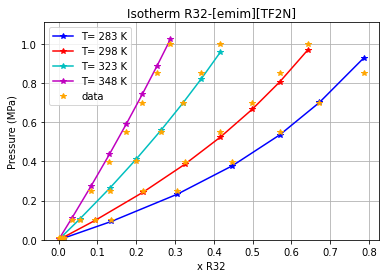

In [13]:
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x[0:7],P1[0:7],"b*-",label="T= 283 K")  
plt.plot(R32_x[7:15],P1[7:15],"r*-",label="T= 298 K") 
plt.plot(R32_x[15:23],P1[15:23],"c*-",label="T= 323 K") 
plt.plot(R32_x[23:31],P1[23:31],"m-*",label="T= 348 K")
plt.plot(data_full["x_R32"],data_full["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R32-[emim][TF2N]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R32')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

### Print Eigvals, Eigvectors

An identifiability analysis can be performed with these as well as a FIM because the covariance matrix is the inverse of the FIM. That means that if there are any eigvals > 0, their eigvecs indicate directions of un-identifiability.

In [14]:
eigvals, eigvecs = np.linalg.eig(cov)

In [15]:
eigvals

array([4.19158041e-03, 1.03712358e-08, 1.24796803e-04])

In [16]:
eigvecs

array([[ 0.03409892,  0.99905186,  0.0270676 ],
       [ 0.80847605, -0.0434959 ,  0.58691957],
       [-0.58754042, -0.00187018,  0.80919266]])

In [17]:
np.savetxt('Data/EigenAnalysis/SRK_vals_3parameter_HFCILB0.csv',eigvals,delimiter=',')
np.savetxt('Data/EigenAnalysis/SRK_vecs_3parameter_HFCILB0.csv',eigvecs,delimiter=',')

Conclusion: 

In [18]:
FIM = np.linalg.inv(cov) 

#A_opt
FIM_trace = np.trace(FIM)
cov_trace = np.trace(cov)

#D_opt
FIM_det = np.linalg.det(FIM)

#E_opt
eigvals_FIM, eigvecs_FIM = np.linalg.eig(FIM)
eigvals_FIM_min = eigvals_FIM.min()

np.savetxt('Data/EigenAnalysis/SRK_FIMtrdet_3parameter_HFCILB0.csv',[cov_trace,FIM_trace,FIM_det,eigvals_FIM_min])
np.savetxt('Data/EigenAnalysis/SRK_FIMvals_3parameter_HFCILB0.csv',eigvals_FIM,delimiter=',')
np.savetxt('Data/EigenAnalysis/SRK_FIMvecs_3parameter_HFCILB0.csv',eigvecs_FIM,delimiter=',')

## AIC Value

See https://docs.google.com/document/d/1um0r2XK4ldjjy2colOqaZsEM3wIzGD6l_3B8gnpnI2I/edit# for equations

In [19]:
n = 3

In [20]:
SSR = obj_value

In [21]:
sigma_sq = SSR/n
sigma_sq

0.27990323031622966

In [22]:
L = -n/2*np.log(2*np.pi) - n/2*np.log(sigma_sq) - 1/(2*sigma_sq)*SSR
L

-2.3468485872712055

In [23]:
AIC = 2*n - 2*L
AIC

10.693697174542411

In [24]:
AIC_data = pd.DataFrame(data=[n,obj_value,AIC])
AIC_data = AIC_data.T
AIC_data.columns = ['n','Objective, Pa^2','AIC']
AIC_data.to_csv('Data/AIC/SRK_AIC_3parameter_HFCILB0.csv')